# Collect data from local

In [2]:
from google.colab import files

uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [3]:
!unzip -q dataset.zip -d ./dataset


In [4]:
!ls ./dataset


README.dataset.txt  README.roboflow.txt  test  train  valid


In [5]:
!ls ./dataset/train | head -20

_classes.csv
img100_jpeg.rf.2f45484c5ad94afc5e1cbbdc437f30e4.jpg
img100_jpeg.rf.2f45484c5ad94afc5e1cbbdc437f30e4_mask.png
img102_jpg.rf.69e11a38dfcf18c85323a1bfac43cfde.jpg
img102_jpg.rf.69e11a38dfcf18c85323a1bfac43cfde_mask.png
img104_jpg.rf.aff340b7241aec0911e417cc85c633cd.jpg
img104_jpg.rf.aff340b7241aec0911e417cc85c633cd_mask.png
img106_jpg.rf.827e86fbcba14c65284f0c2c82bb8a51.jpg
img106_jpg.rf.827e86fbcba14c65284f0c2c82bb8a51_mask.png
img107_jpg.rf.36377f69544465d03b817f2c1d32cd55.jpg
img107_jpg.rf.36377f69544465d03b817f2c1d32cd55_mask.png
img108_jpg.rf.72fe3c8bdf6e26585362b679c45228fb.jpg
img108_jpg.rf.72fe3c8bdf6e26585362b679c45228fb_mask.png
img109_jpg.rf.14fb4ea560a19374f062fca7c44c9893.jpg
img109_jpg.rf.14fb4ea560a19374f062fca7c44c9893_mask.png
img10_jpg.rf.b72605b0a3039a4ae0c175f04cd44e39.jpg
img10_jpg.rf.b72605b0a3039a4ae0c175f04cd44e39_mask.png
img111_jpg.rf.6b1613d11ae4a862d9ac753a75ef93e6.jpg
img111_jpg.rf.6b1613d11ae4a862d9ac753a75ef93e6_mask.png
img112_jpeg.rf.b891b9f07

# Import Libraries

In [6]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from matplotlib.colors import ListedColormap

In [7]:
IMG_SIZE = 256
BATCH_SIZE = 16


In [8]:
def load_image_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0  # normalize image

    # Load mask (grayscale)
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE), method='nearest')
    mask = tf.cast(mask, tf.uint8)  # class labels as integers

    return image, mask


In [9]:
def get_image_mask_pairs(folder):
    files = os.listdir(folder)
    images = sorted([f for f in files if f.endswith('.jpg') or f.endswith('.jpeg')])
    image_paths = []
    mask_paths = []

    for img in images:
        base_name = os.path.splitext(img)[0]
        mask_name = base_name + '_mask.png'
        if mask_name in files:
            image_paths.append(os.path.join(folder, img))
            mask_paths.append(os.path.join(folder, mask_name))
        else:
            print(f"Warning: Mask not found for {img}")
    return image_paths, mask_paths

In [10]:
def get_dataset(folder, batch_size=BATCH_SIZE, shuffle=True):
    image_paths, mask_paths = get_image_mask_pairs(folder)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.map(lambda x, y: load_image_mask(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = get_dataset('./dataset/train', shuffle=True)
valid_dataset = get_dataset('./dataset/valid', shuffle=False)
test_dataset = get_dataset('./dataset/test', shuffle=False)


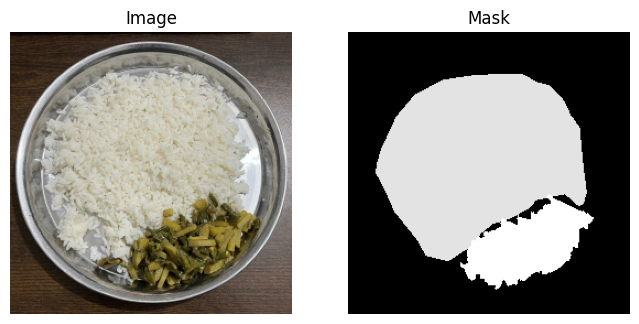

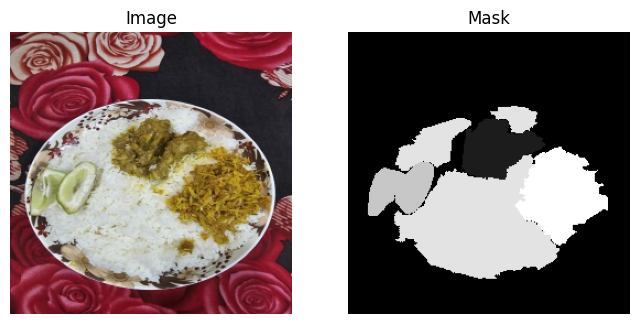

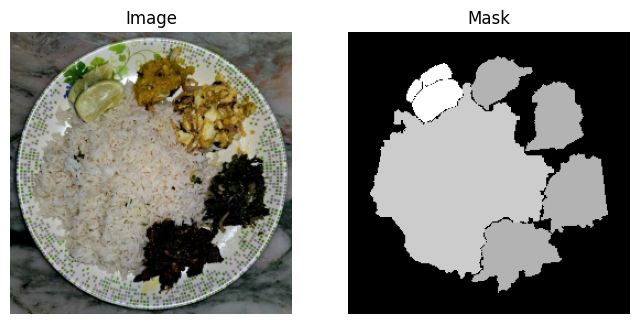

In [11]:
def display_sample(dataset, num=3):
    for images, masks in dataset.take(1):
        for i in range(num):
            plt.figure(figsize=(8,4))
            plt.subplot(1,2,1)
            plt.title("Image")
            plt.imshow(images[i])
            plt.axis('off')

            plt.subplot(1,2,2)
            plt.title("Mask")
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.axis('off')
            plt.show()

display_sample(train_dataset, num=3)

In [12]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D(2)(c2)

    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D(2)(c3)

    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(2)(c4)

    # Bridge
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)

    num_classes = 11  # number of segmentation classes

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)


    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,032,395 (118.38 MB)

 Trainable params: 31,032,395 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
EPOCHS = 20

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.3690 - loss: 2.5049  

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


5/5 ━━━━━━━━━━━━━━━━━━━━ 166s 21s/step - accuracy: 0.3950 - loss: 2.5355 - val_accuracy: 0.6734 - val_loss: 2.0510
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 777ms/step - accuracy: 0.6582 - loss: 2.0572 - val_accuracy: 0.2146 - val_loss: 1.7311
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 851ms/step - accuracy: 0.3103 - loss: 1.6693 - val_accuracy: 0.6734 - val_loss: 1.3136
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 798ms/step - accuracy: 0.6820 - loss: 1.2579 - val_accuracy: 0.6734 - val_loss: 1.0792
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 855ms/step - accuracy: 0.6824 - loss: 1.1337 - val_accuracy: 0.6734 - val_loss: 0.9706
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 832ms/step - accuracy: 0.6813 - loss: 0.9884 - val_accuracy: 0.6734 - val_loss: 0.8910
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 873ms/step - accuracy: 0.7043 - loss: 0.8142 - val_accuracy: 0.7980 - val_loss: 0.7304
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 859ms/step - accuracy: 0.7503 - loss: 0.7404 - val_accuracy: 0.7794 - val_loss: 0.6649
Ep

In [15]:
# Save the trained model
model.save("meal_segmentation_unet_model.h5")
print("✅ Model saved!")


✅ Model saved!


In [16]:
# NUM_CLASSES = 12

# # Create a discrete colormap with distinct colors for each class
# colors = plt.cm.get_cmap('tab20', NUM_CLASSES).colors
# cmap = ListedColormap(colors)

# def display_sample_predictions(dataset, num_samples=5):
#     for image_batch, mask_batch in dataset.take(1):
#         preds = model.predict(image_batch)
#         preds = tf.argmax(preds, axis=-1)
#         masks = tf.argmax(mask_batch, axis=-1)

#         for i in range(num_samples):
#             plt.figure(figsize=(12, 4))

#             # Original image
#             plt.subplot(1, 3, 1)
#             plt.imshow(image_batch[i])
#             plt.title("Original Image")
#             plt.axis("off")

#             # Ground truth mask with discrete colormap
#             plt.subplot(1, 3, 2)
#             plt.imshow(masks[i].numpy(), cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
#             plt.title("Ground Truth Mask")
#             plt.axis("off")

#             # Predicted mask with discrete colormap
#             plt.subplot(1, 3, 3)
#             plt.imshow(preds[i].numpy(), cmap=cmap, vmin=0, vmax=NUM_CLASSES-1)
#             plt.title("Predicted Mask")
#             plt.axis("off")

#             plt.tight_layout()
#             plt.show()

# # Run this function on your test dataset to see predictions
# display_sample_predictions(test_dataset)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(16, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


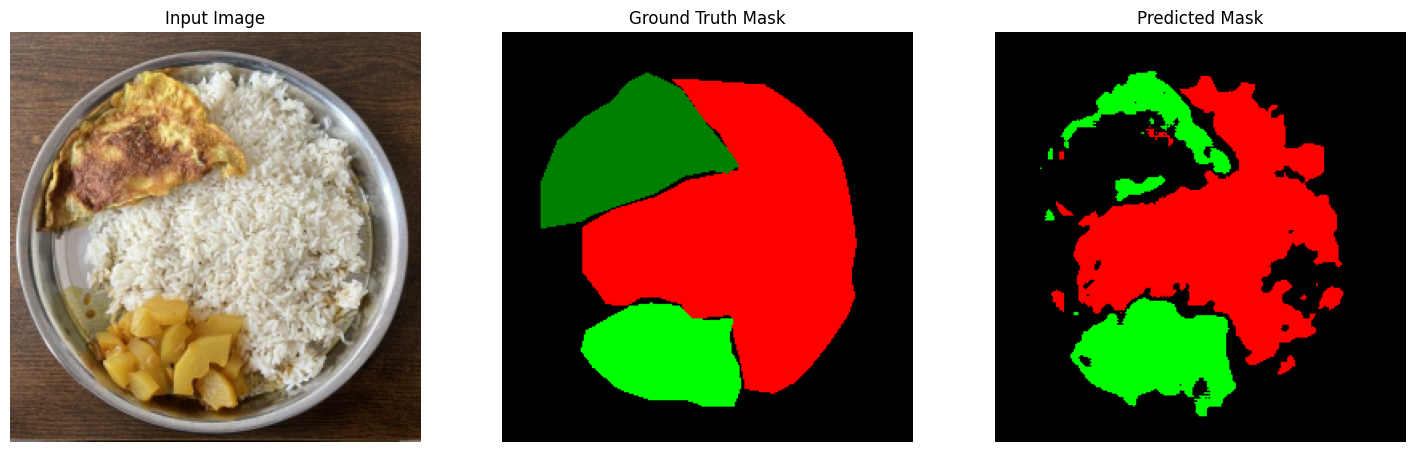

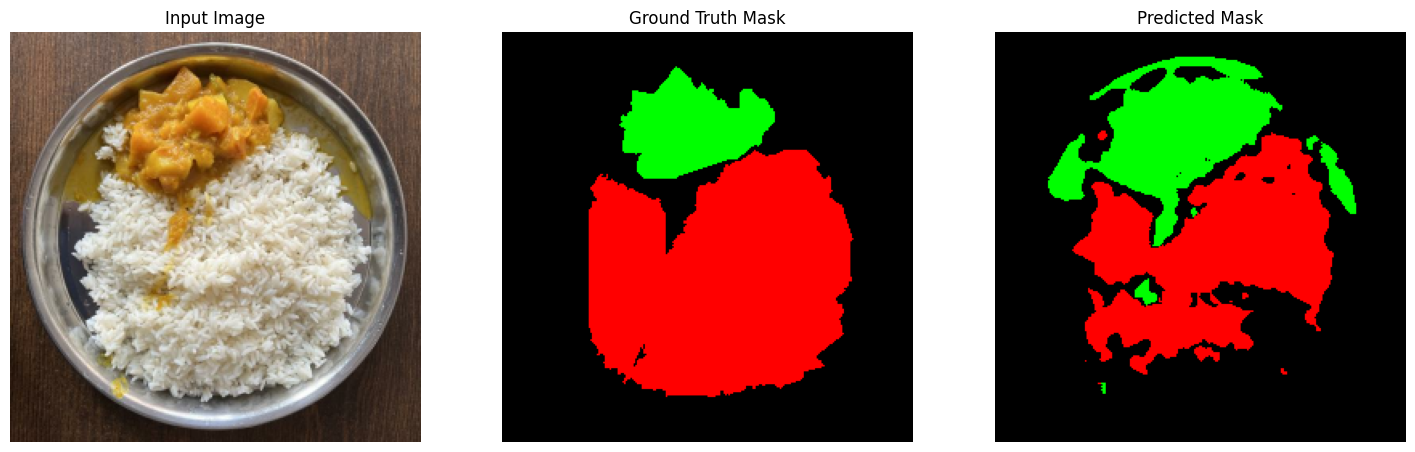

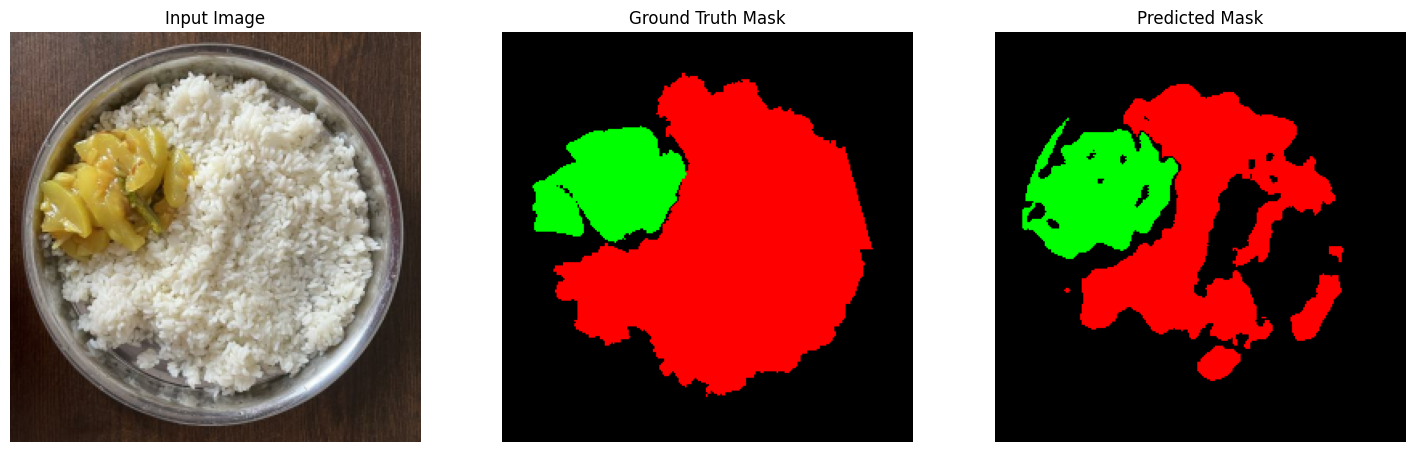

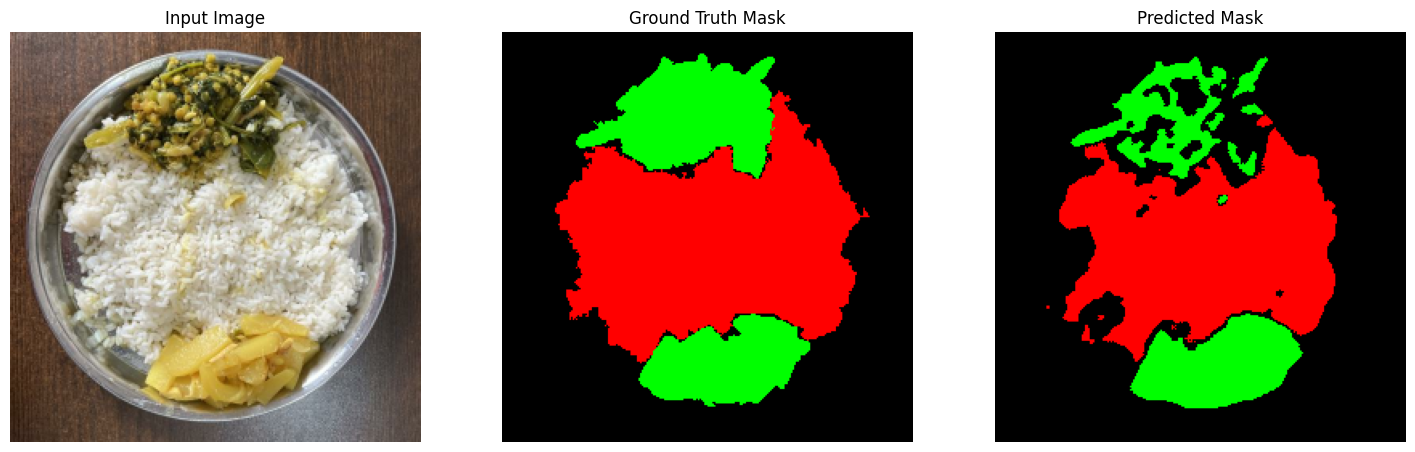

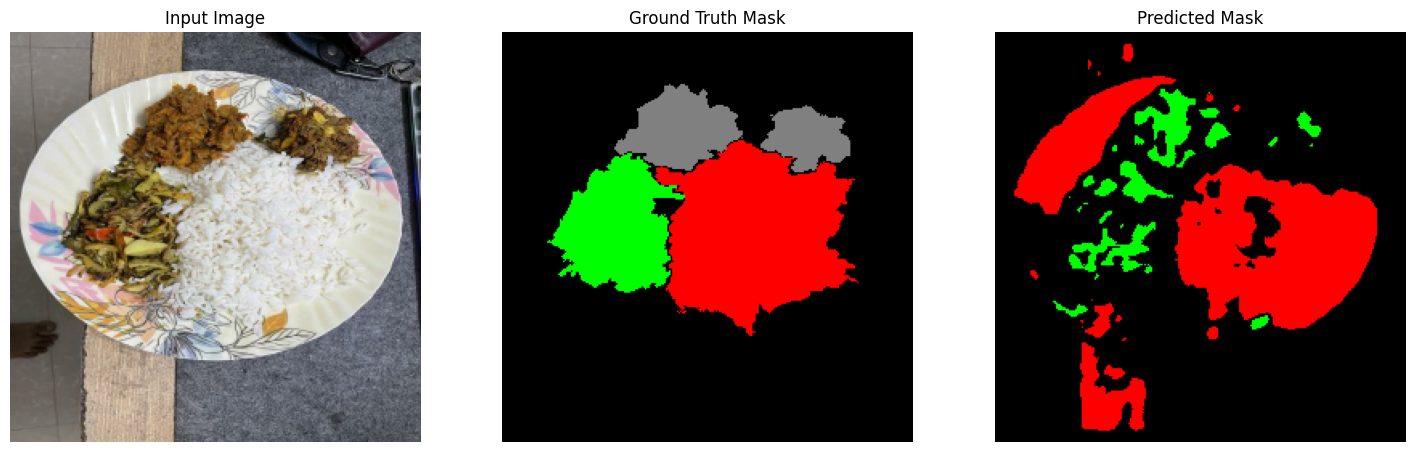

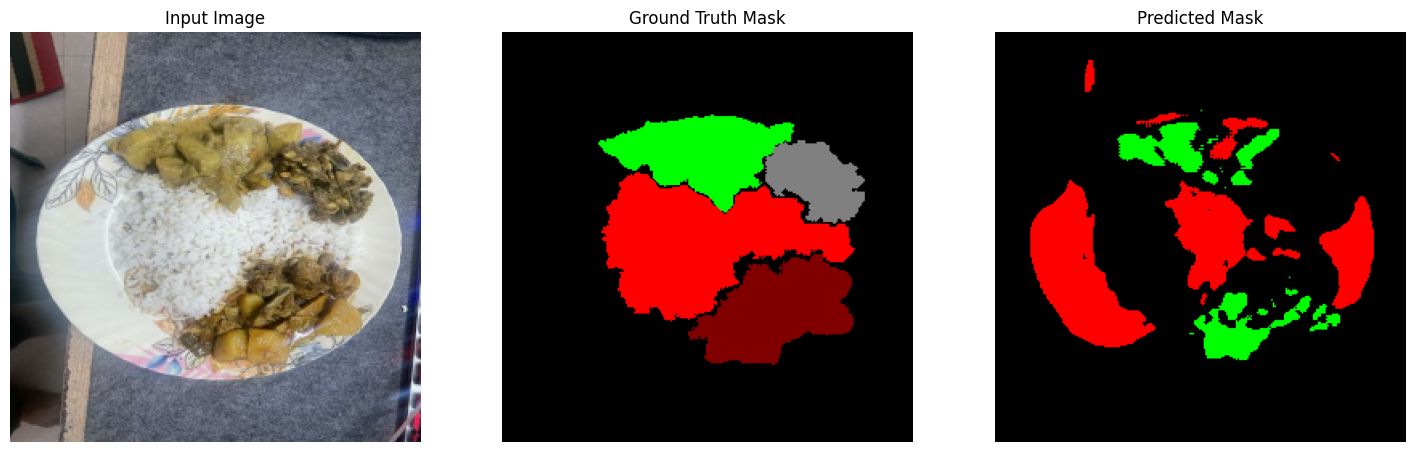

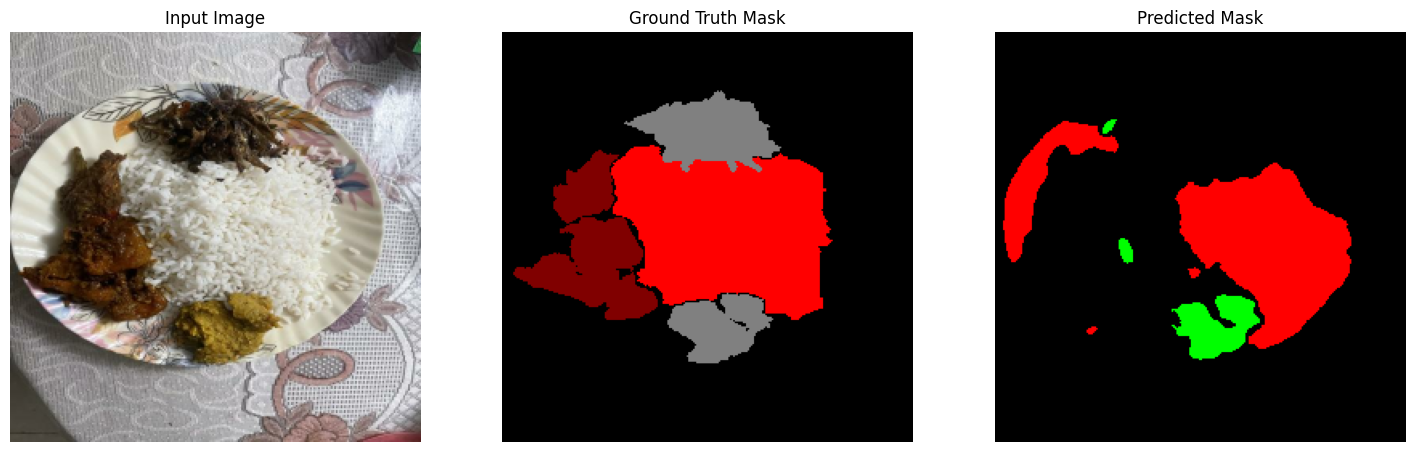

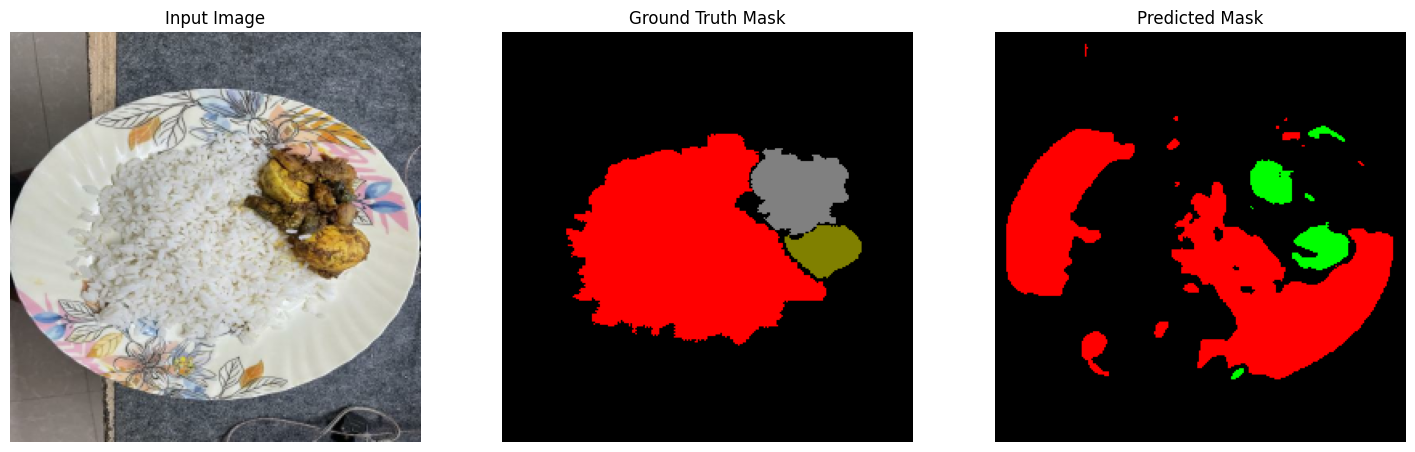

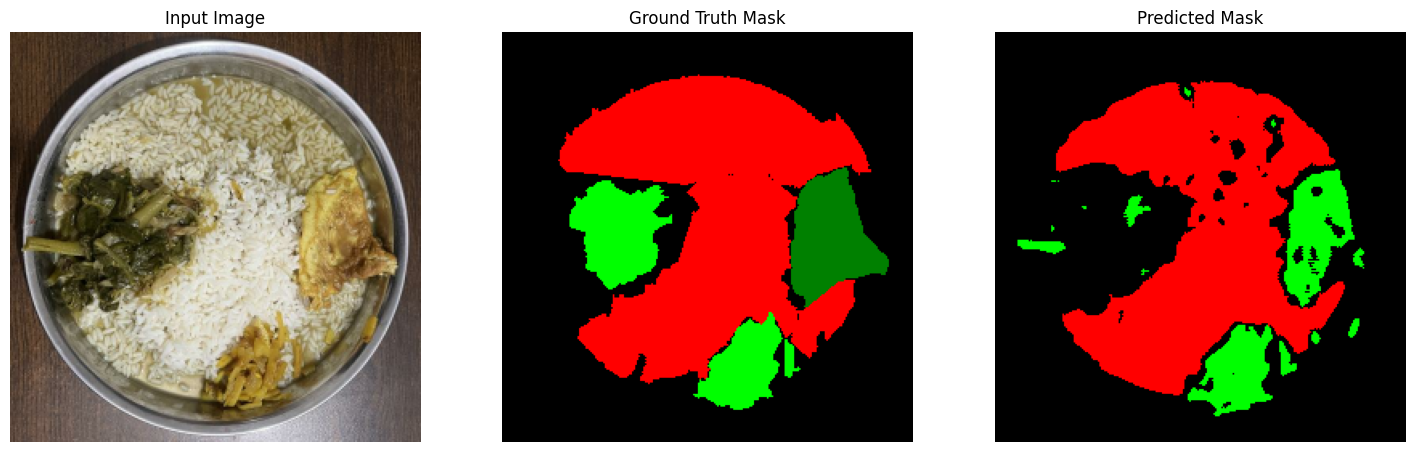

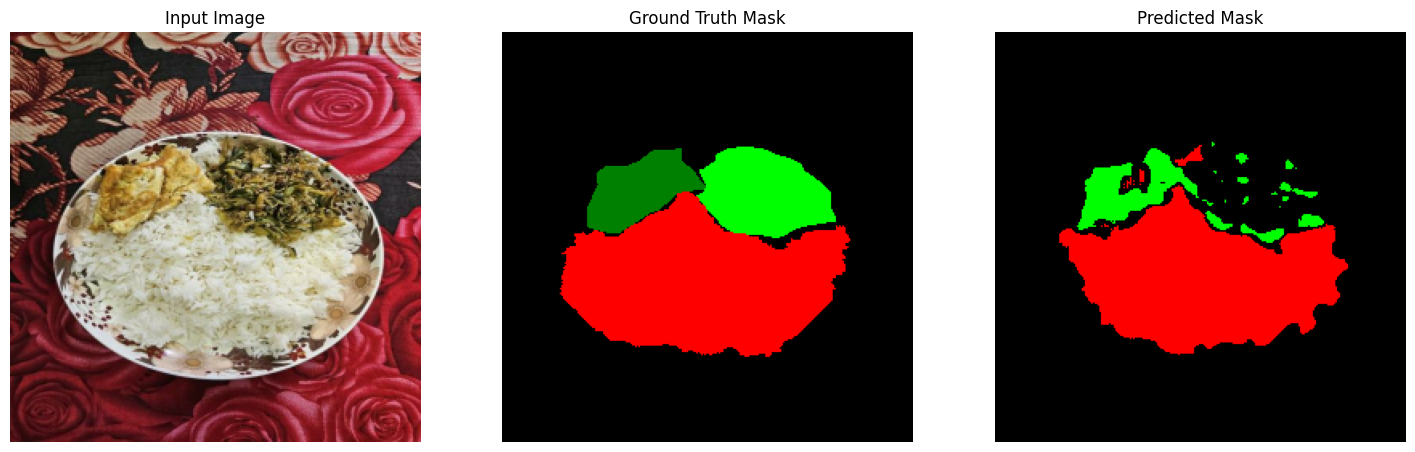

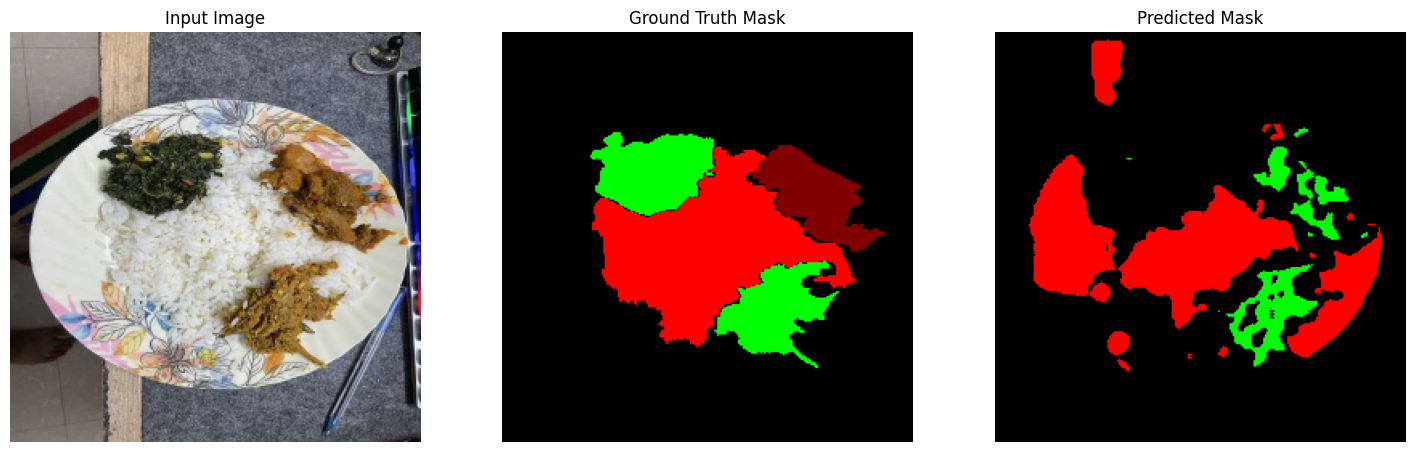

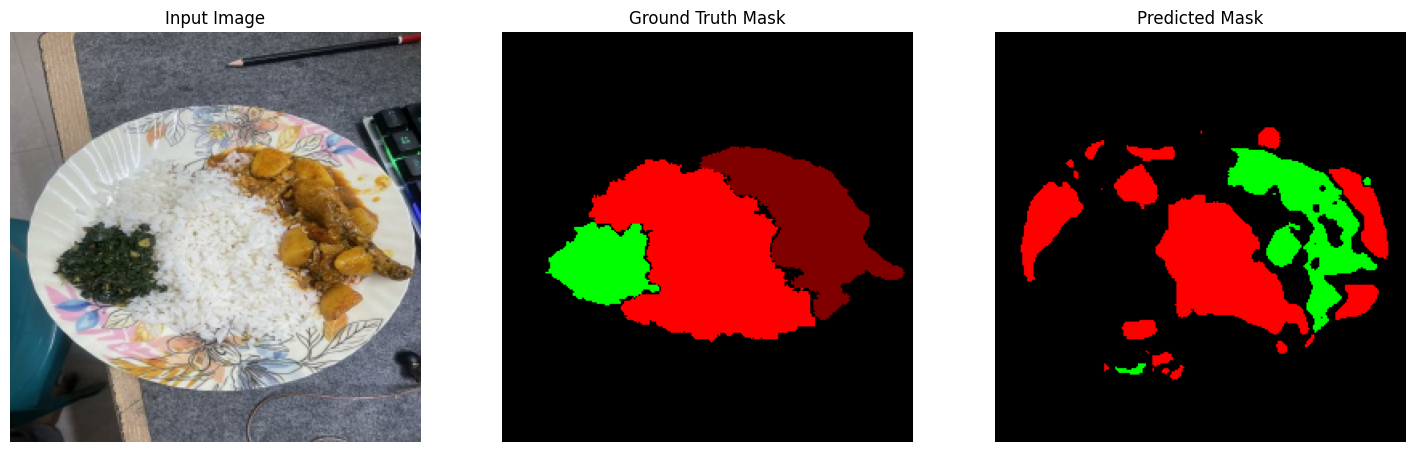

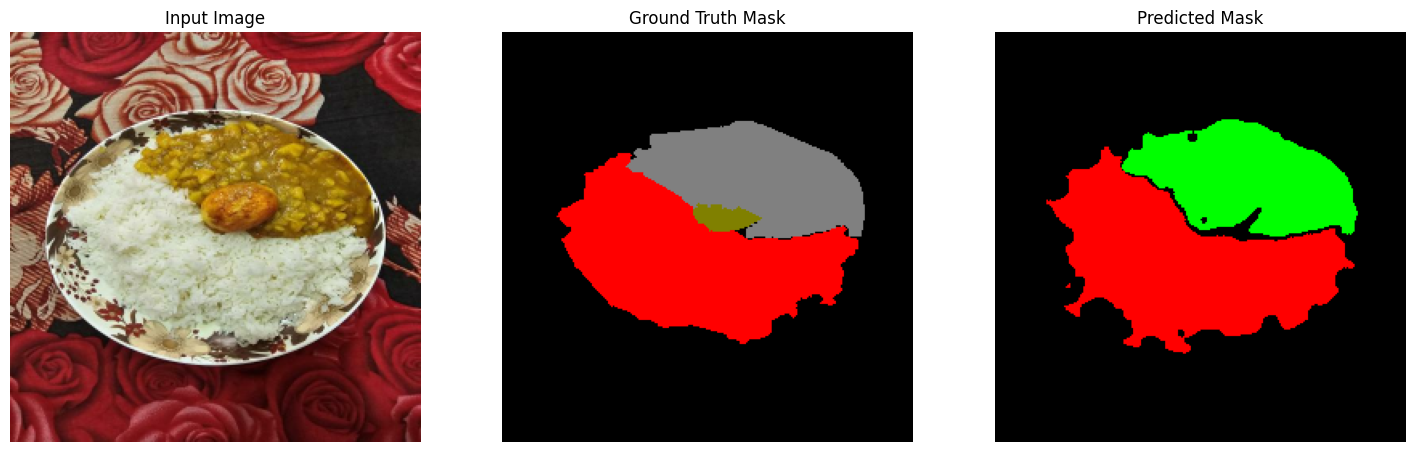

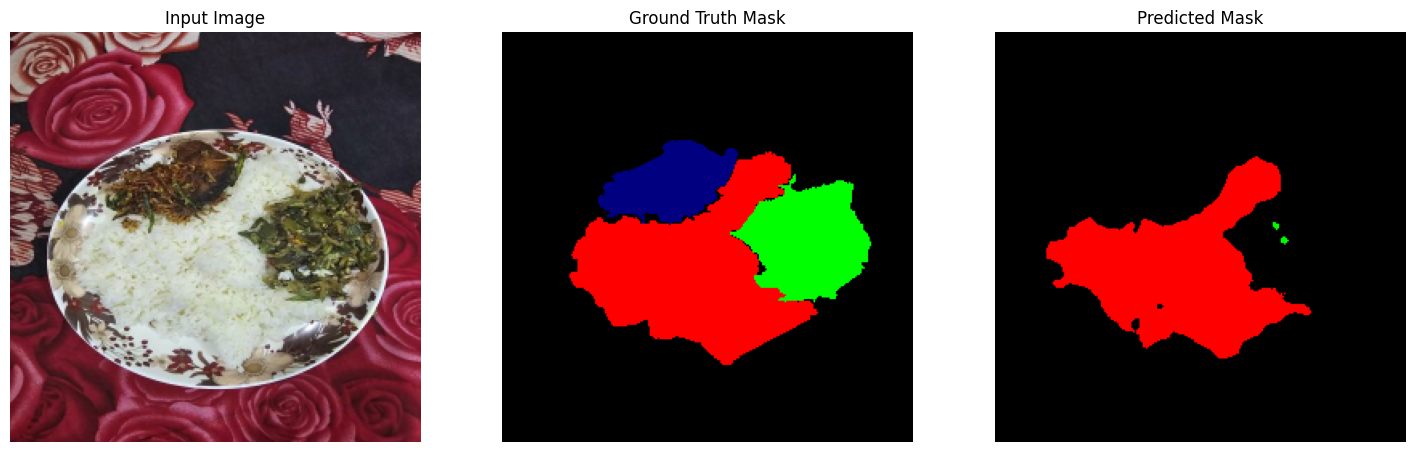

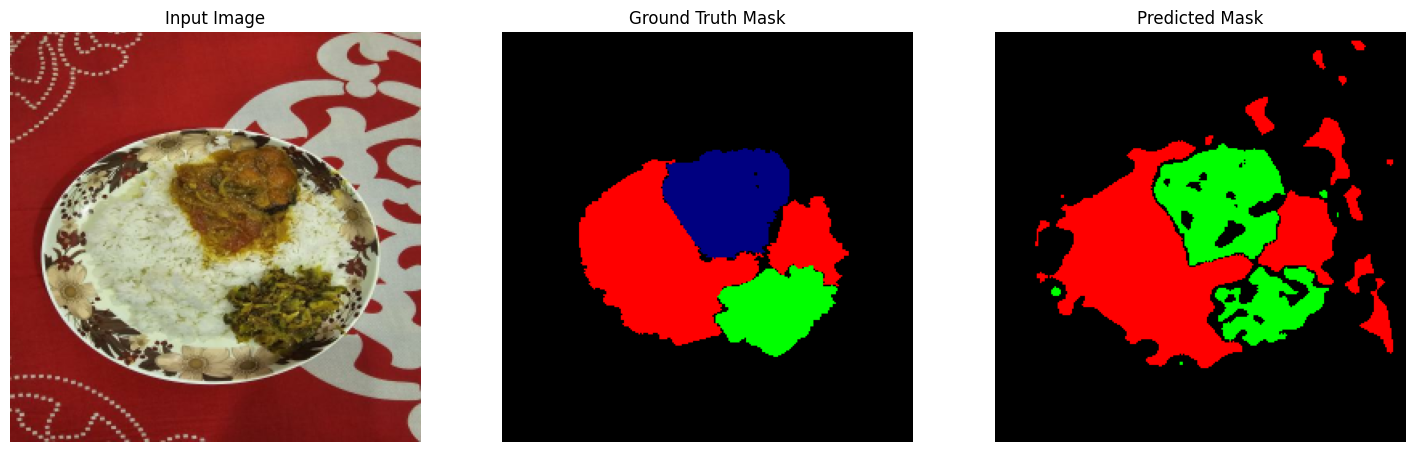

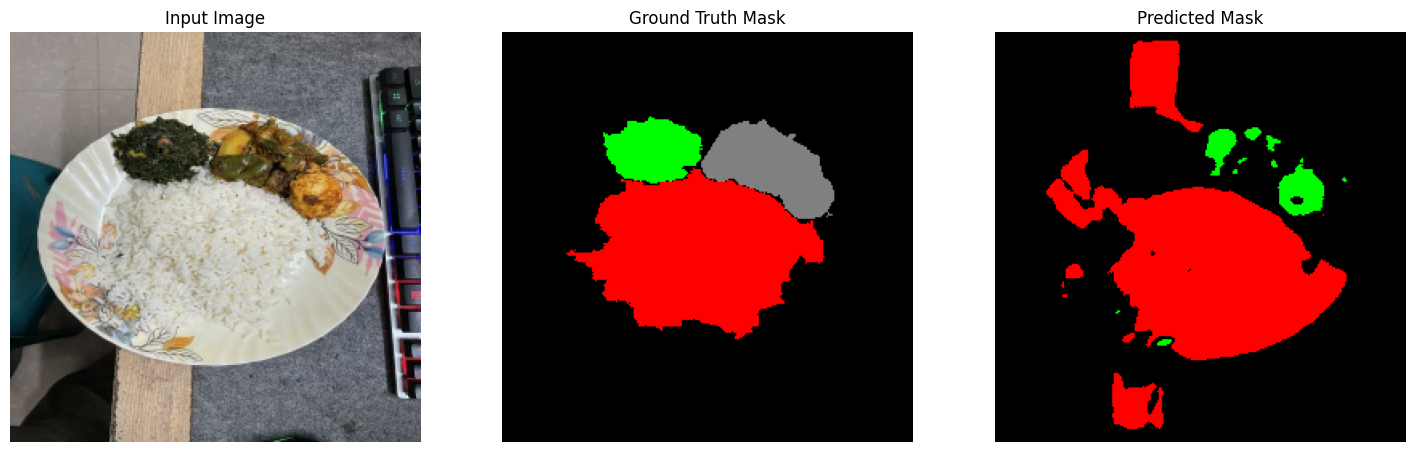

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def apply_color_map(mask, class_colors):
    """
    Convert 2D mask of class indices to RGB mask using class_colors.
    """
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_idx, color in enumerate(class_colors):
        color_mask[mask == cls_idx] = color
    return color_mask

def visualize_predictions(model, dataset, class_colors, num_batches=1):
    for images, true_masks in dataset.take(num_batches):
        preds = model.predict(images)
        preds = tf.argmax(preds, axis=-1).numpy()
        true_masks = tf.squeeze(true_masks, axis=-1).numpy()

        batch_size = images.shape[0]
        for i in range(batch_size):
            plt.figure(figsize=(18,6))

            # Original Image
            plt.subplot(1,3,1)
            plt.title("Input Image")
            img = images[i].numpy()
            if img.max() <= 1.0:
              plt.imshow(img)
            else:
              img_uint8 = (img / img.max() * 255).astype(np.uint8)
              plt.imshow(img_uint8)
            plt.axis('off')


            # Ground Truth Mask
            plt.subplot(1,3,2)
            plt.title("Ground Truth Mask")
            gt_mask_color = apply_color_map(true_masks[i], class_colors)
            plt.imshow(gt_mask_color)
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1,3,3)
            plt.title("Predicted Mask")
            pred_mask_color = apply_color_map(preds[i], class_colors)
            plt.imshow(pred_mask_color)
            plt.axis('off')

            plt.show()

# Define colors for each class index
class_colors = [
    (0, 0, 0),         # class 0 - background - black
    (128, 0, 0),       # class 1 - dark red
    (0, 128, 0),       # class 2 - dark green
    (128, 128, 0),     # class 3 - olive
    (0, 0, 128),       # class 4 - navy
    (128, 0, 128),     # class 5 - purple
    (0, 128, 128),     # class 6 - teal
    (128, 128, 128),   # class 7 - gray
    (255, 0, 0),       # class 8 - red
    (0, 255, 0),       # class 9 - bright green
    (0, 0, 255),       # class 10 - blue (Veg)
    (255, 255, 0),     # class 11 - yellow (Salad)
]
visualize_predictions(model, valid_dataset, class_colors, num_batches=1)


# Testing

In [25]:
import cv2

# Set path to one test image and mask
test_image_path = './dataset/test/img25_jpeg.rf.5f1dc529cefc0c5be7d541fcb47975fe.jpg'
test_mask_path = './dataset/test/img25_jpeg.rf.5f1dc529cefc0c5be7d541fcb47975fe_mask.png'

# Load image
img = tf.io.read_file(test_image_path)
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.resize(img, (256, 256))
img = img / 255.0

# Load mask (optional)
mask = tf.io.read_file(test_mask_path)
mask = tf.image.decode_png(mask, channels=1)
mask = tf.image.resize(mask, (256, 256), method='nearest')


In [26]:
input_img = tf.expand_dims(img, axis=0)  # Shape (1, 256, 256, 3)

In [27]:
pred_mask = model.predict(input_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


In [28]:
pred = model.predict(input_img)
pred_mask = np.argmax(pred, axis=-1)
pred_mask = pred_mask[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [29]:
class_names = [
    "background", "0", "Chicken_curry", "EGG", "EGG_s",
    "Fish", "Khichuri", "Meat", "Others", "Rice",
    "Veg", "salad"
]


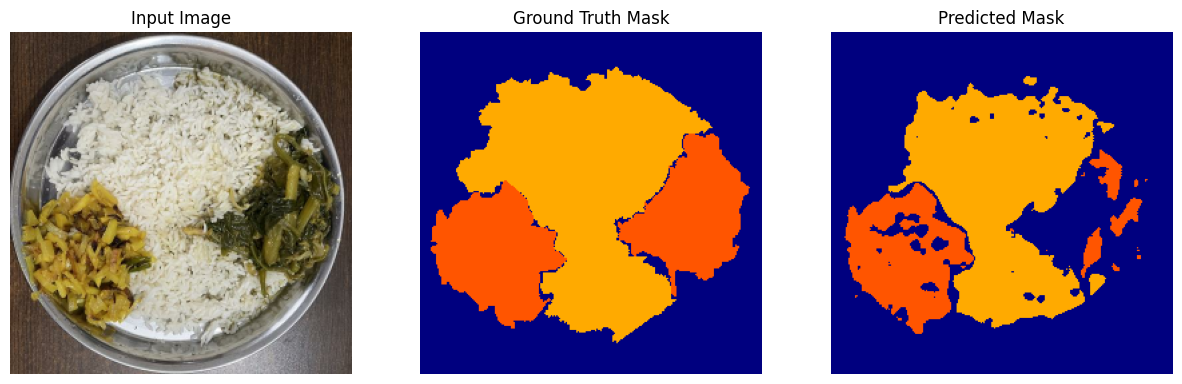

In [30]:
num_classes = 12

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Input Image")
plt.imshow(img.numpy())
plt.axis('off')

plt.subplot(1,3,2)
plt.title("Ground Truth Mask")
plt.imshow(mask.numpy().squeeze(), cmap='jet', vmin=0, vmax=num_classes-1)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Predicted Mask")
plt.imshow(pred_mask, cmap='jet', vmin=0, vmax=num_classes-1)
plt.axis('off')

plt.show()
